# Author: Olivia McAuley
August 7, 2023

In [1]:
import numpy as np

import seaborn as sb
import scipy as sc
from scipy.signal import argrelextrema
from scipy import stats

from statistics import mean

import astropy
from astropy import units
from astropy import units as u
from astropy import constants as c
from astropy.constants import G

import galpy
import galpy.df
from galpy.df import isotropicPlummerdf 
from galpy.orbit import Orbit
from galpy import potential
from galpy.potential import PlummerPotential, MWPotential2014, DehnenBarPotential
from galpy.potential import RotateAndTiltWrapperPotential, SolidBodyRotationWrapperPotential
from galpy.potential import MovingObjectPotential
from galpy.potential import evaluatePotentials, plotPotentials, plotDensities, flatten, rhalf, vcirc, to_amuse
from galpy.potential import plotRotcurve, lindbladR, epifreq, vesc
from galpy.actionAngle import actionAngleAdiabatic, actionAngleStaeckel
from galpy.util import conversion, coords
from galpy.util.plot import dens2d, scatterplot
from galpy.util.conversion import get_physical

from datetime import datetime

import matplotlib
import pylab
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
plt.rc('text', usetex=False)
plt.rc('font', **{'family':'DejaVu Sans','size':20})
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
import matplotlib.colors as colors
from matplotlib import colors as mc
from matplotlib import cm
from matplotlib.colors import LogNorm
# %matplotlib inline

from matplotlib import mlab as ml
import matplotlib.animation as manimation
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

from IPython.display import HTML
from matplotlib.patches import Ellipse

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Users/oliviamcauley/miniconda3/envs/physics/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


A new version of galpy (1.9.2) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


# Underlying Milky Way Potential

In [2]:
mwp = MWPotential2014

# Scale Factors

In [3]:
##### Important scale factors #####

# Scales to be use for conversion from natural coordinates
ro = 8. # (kpc) scale radii
vo = 220. # (km/s) scale velocity at ro

# Set model parameters for potentials and DF:
hro  = 1./3.   # Scale length for surface density
sro  = 0.16    # Radial velocity dispersion at ro in natural coordinates (times vo to get in physical at ro)
szo  = sro/2   # Vertical velocity dispersion at ro in natural coordinates (times vo to get in physical at ro)
hsro = 3.*hro #3./4.    # Radial scale length for radial velocity dispersion profile
hszo = hsro    # Radial scale length for vertical velocity dispersion profile

# Set parameters for initial conditions
nsample = 100 #1000     # number of samples
nbatch = 10       # number of batches of nsample orbits
rmin = 0.375 # sets scaled rmin = 3kpc
rmax = 1.125 # sets scaled rmax = 9kpc
zmax=0.3    # sets scales zmax = 2.4 kpc
AAType = 'stklAA' # Action Angle approx for ICs
dpType = 'MW14'
dfType = 'N_ppDF_'

# Run Files in Slow Bar Folder to Get the Calculator to Work

In [4]:
%run ./Slowing-Bar/TSolidBodyRotationWrapperPotential.ipynb
%run ./Slowing-Bar/SimParams.ipynb
%run ./Slowing-Bar/DiskModel.ipynb
%run ./Slowing-Bar/DehnenBarModel_Omega.ipynb

/Users/oliviamcauley/miniconda3/envs/physics/lib/python3.8/site-packages/galpy/util/conversion.py:832: UserWarning: Returning output(s) in internal units even though use_physical=True, because ro and/or vo not set
  warnings.warn("Returning output(s) in internal units even though use_physical=True, because ro and/or vo not set")



### Times relevant to integration



STEP 1: Find length of each timestep for adequate resolution


For adequate resolution, want timestep to be
   dtmaxPhys <0.75 Myr in physical units, which is equal to 
   dtmaxNat <0.0021 in natural units


Use these to define conversion factor:
   NatToGyrConversion = dtmaxPhys/dtmaxNat =  35.56 Myr per natural time unit


Slowing period for the bar is set to:
   TSlowPhys =  8.0 Gyr  in physical units and
   TSlowNat =  225.0  in natural units


Therefore the total number of timesteps should be:
   Nsteps > TSlow/dtmax =  10713.2
The number of steps is set to Nsteps = 16000
   where each step has length tstepPhys ~ 0.5 Myr in physical units
   and tstepNat ~ 0.01406  in natural time units


STEP 2: Identify timestamp for each rotation of the slowing bar


The array measuring time in natural units spaced by tstepNat is called tvector
   and has length len(tvector) =  16000


Inital pattern speed is omegaBi =  2.02  [natural units]
   As such a sin

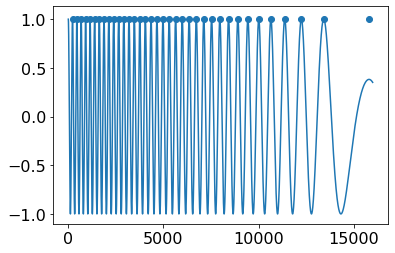

In [5]:
# %%capture cap --no-stderr

#### HARD ENTERED VALUES ###

TMaxDivFactor = 10 # Factor to divide circular orbital period at rmin
Nsteps = 16000 # Hard entered after COMMENTING OUT lines 49-50

print('### Times relevant to integration\n')
print('\n')

### Find length of each timestep for adequate resolution ###
print('STEP 1: Find length of each timestep for adequate resolution')
print('\n')

def timescalePhys(R,vc): # <-- use R [kpc] and vc [km/s]
    R = R *u.kpc
    vc = vc *u.km/u.s
    T = 2 *np.pi *R/vc
    return T.to(u.Myr)
def timescaleNat(R,vc): # <-- use natural units
    R = R
    vc = vc
    T = 2 *np.pi *R/vc 
    return T
dtmaxPhys = timescalePhys(rmin*ro,vcirc(mwp,rmin,vo=vo,ro=ro))/TMaxDivFactor
dtmaxNat  = timescaleNat(rmin,vcirc(mwp,rmin))/TMaxDivFactor

NatToGyrConversion = dtmaxPhys/dtmaxNat # <-- Conversion factor
print('For adequate resolution, want timestep to be')
print('   dtmaxPhys <'+str(np.round(dtmaxPhys,2))+' in physical units, which is equal to ')
print('   dtmaxNat <'+str(np.round(dtmaxNat/10,4))+' in natural units')
print('\n')

print('Use these to define conversion factor:')
print('   NatToGyrConversion = dtmaxPhys/dtmaxNat = ',np.round(NatToGyrConversion,2),'per natural time unit')
print('\n')

TSlowNat = ((TSlowPhys/NatToGyrConversion).decompose()).value
print('Slowing period for the bar is set to:')
print('   TSlowPhys = ',TSlowPhys,' in physical units and')
print('   TSlowNat = ',np.round(TSlowNat,2),' in natural units')
print('\n')

ntstepApprox = ((TSlowPhys/dtmaxPhys).decompose()).value
print('Therefore the total number of timesteps should be:')
print('   Nsteps > TSlow/dtmax = ',np.round(ntstepApprox,1))
# sNsteps = input("Please choose an integer number of steps that is greater than this number: ")
# Nsteps = int(sNsteps)

tstepPhys = TSlowPhys/Nsteps
tstepNat = ((tstepPhys/NatToGyrConversion).decompose()).value
print('The number of steps is set to Nsteps =',Nsteps)
print('   where each step has length tstepPhys ~',np.round(tstepPhys.to(u.Myr),3),'in physical units')
print('   and tstepNat ~',np.round(tstepNat,5),' in natural time units')
print('\n')

## Find times for each slowing bar rotation
print('STEP 2: Identify timestamp for each rotation of the slowing bar')
print('\n')

tvector = np.arange(to,TSlowNat,tstepNat)
print('The array measuring time in natural units spaced by tstepNat is called tvector')
print('   and has length len(tvector) = ',len(tvector))
print('\n')

TbariNat = 2.*np.pi/omegaBi
TbarfNat = 2.*np.pi/omegaBf
TbariPhys = (TbariNat*NatToGyrConversion).to(u.Gyr)
TbarfPhys = (TbarfNat*NatToGyrConversion).to(u.Gyr)
print('Inital pattern speed is omegaBi = ',np.round(omegaBi,2),' [natural units]')
print('   As such a single bar period is: (using T = 2 pi / Omega_B)')
print('   TbariNat =',np.round(TbariNat,2),' natural units')
print('   TbariPhys =',np.round(TbariPhys,2),' physical units')
print('   Corotation at CRi =',np.round( (TbariPhys*vcirc(mwp,CRi,vo=vo,ro=ro)*u.km/u.s/(2.*np.pi)).to(u.kpc), 2),' physical units')

print('Final pattern speed is omegaBf = ',np.round(omegaBf,2),' [natural units]')
print('   As such a single bar period is:')
print('   TbarfNat =',np.round(TbarfNat,2),' natural units')
print('   TbarfPhys =',np.round(TbarfPhys,2),' physical units')
print('   Corotation at CRf =',np.round( (TbarfPhys*vcirc(mwp,CRf,vo=vo,ro=ro)*u.km/u.s/(2.*np.pi)).to(u.kpc), 2),' physical units')
print('\n')

def findomegat(omegai, omegaf, t):
    dO = omegaf-omegai
    dt = t[-1]-t[0]#ttot
    omegat= dO/dt *(t-t[0]) + omegai
    return omegat 
omegat = findomegat(omegaBi,omegaBf,tvector)
print('The bar pattern speed is defined as:')
print('   omegat = [(omegaBf - omegaBi) / TSlow] x (t-t0) + omegaBi')
print('   where t0 is the initial time')
print('The array with length',len(omegat),'giving the time dependent pattern speed is named omegat')
# Plot test (pl.plot) shows linear decrease over time as expected

def findphit(omegai, omegat, t):
    phit = omegat*t + omegai*t[0]
    return phit
phit = findphit(omegaBi,omegat,tvector)
print('The angle of the bar pattern over time:')
print('   phit = omegat x (t-t0) + omegaBi x to')
print('   where phit is implicitly in units of radians')
print('The array with length',len(phit),'giving the time dependent angle of the bar is named phit')
print('\n')

cosphit = np.cos(phit*u.rad)
maxpoints = argrelextrema(cosphit, np.greater)
endmwCR = lindbladR(mwp,omegat[maxpoints[0][-1]],m='corotation')*ro*u.kpc
print('In order to take snapshot when the bar is aligned with x=0')
print('   must find the timestamp when phi=0 for each rotation.')
print('Since phi(to)=0, cos(phi(to))=1')
print('   the local maxima in function cos(phit) will closely approximate x=0 for snapshots.')
print('The array called maxpoints gives the indices of the ',len(maxpoints[0]),' maxima in cos(phit).')
print('   This implies that the bar makes',len(maxpoints[0]),'full rotations in',TSlowPhys)
print('\n')

print('Important Note: The last index indicating x=0 is not the last step in the simulation,')
print('   rather it is at step i = ',maxpoints[0][-1],',')
print('   which is time',np.round(tvector[maxpoints[0][-1]],2),'in natural units and')
print('   and ',np.round((tvector[maxpoints[0][-1]]*NatToGyrConversion).to(u.Gyr),2),'in physical units.')
print('   This implies the final radius of corotation is R_CR=',np.round(endmwCR,2))

print('\n')

print('For reference, these maxima correspond to phi/(2 pi) = ',np.round(phit[maxpoints]/(2.*np.pi),4))
plt.plot(cosphit)    
plt.scatter(maxpoints,np.ones(len(maxpoints[0])))
print (np.shape(tvector))

In [6]:
%run ./Slowing-Bar/BarModelOmegat.ipynb

Check that in SlowingBarModel all values are in natural units.


/Users/oliviamcauley/miniconda3/envs/physics/lib/python3.8/site-packages/galpy/util/conversion.py:832: UserWarning: Returning output(s) in internal units even though use_physical=True, because ro and/or vo not set
  warnings.warn("Returning output(s) in internal units even though use_physical=True, because ro and/or vo not set")

/Users/oliviamcauley/miniconda3/envs/physics/lib/python3.8/site-packages/galpy/potential/PowerSphericalPotentialwCutoff.py:96: RuntimeWarning: invalid value encountered in double_scalars
  out= 2.*numpy.pi*self.rc**(3.-self.alpha)*(1/self.rc*special.gamma(1.-self.alpha/2.)*special.gammainc(1.-self.alpha/2.,(r/self.rc)**2.)-special.gamma(1.5-self.alpha/2.)*special.gammainc(1.5-self.alpha/2.,(r/self.rc)**2.)/r)



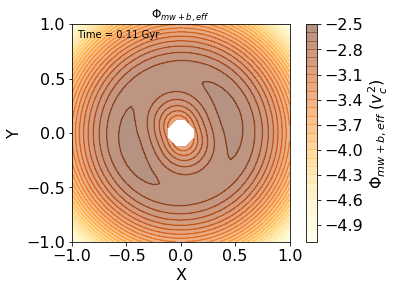

In [7]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)
   
def makeMask(X,Y,Z,Rlimit):
    x, y = np.meshgrid(X, Y)
    R, phi = cart2pol(x,y)
    mask = np.where(R<Rlimit,True,False)
    Z = np.ma.array(Z, mask=mask)
    return Z

def PhiCor(x,y,omegat):
    R, phi = cart2pol(x,y)
    R = R
    Peff = (omegat*R)**2 /2 
    return Peff

def findomegat(omegai, omegaf, t):
    dO = omegaf-omegai
    dt = t[-1]-t[0]#ttot
    omegat= dO/dt *(t-t[0]) + omegai
    return omegat 
omegat = findomegat(omegaBi,omegaBf,tvector)


def findphit(omegai, omegat, t):
    phit = omegat*t + omegai*t[0]
    return phit
phit = findphit(omegaBi,omegat,tvector)

def FindBarPot(x,y,time,phit):# ,omegat,time):#,phitime,last_ts): #time is in nat units
    GyrUnits = NatToGyrConversion.to(u.s)
#     CR = 0.5
#     vo = vcirc(mwp,R=CR) 
#     omegabo = vo/CR
    R,phi = cart2pol(x,y)
    BarPot = evaluatePotentials(mwp+btp, R=R, z=0, phi = phi+phit, t=time)
    return BarPot

##### Set timestamp which will be the element number of tvector #####

timestamp = 223
#########################################

ndim = 49
X = np.linspace(-1, 1, ndim)
Y = np.linspace(-1, 1, ndim)

##### Set radial limit #####
Rl = 0.1  # multiply this radial limit by 8kpc to get physical units
#########################################

P = np.zeros([ndim, ndim])

for i in range(len(X)):
    for j in range(len(Y)):
        P[i, j] = FindBarPot(X[i],Y[j], tvector[timestamp], phit[timestamp]) - PhiCor(X[i],Y[j],omegat[timestamp])

##### Make mask for the plot #####  
# P represents the potential at different grid points in the X-Y plane.
P = makeMask(X,Y,P,Rl)
#########################################

##### Plot the contour lines #####
cmap='YlOrBr'
Lcolor = 'black'

fig, ax = plt.subplots()
ax.set_aspect('equal')

cp = plt.contourf(X, Y, P, levels=25, cmap=cmap,alpha=0.5)#, vmin=-5.3, vmax=-2.6)
plt.contour(X, Y, P, levels=25, cmap=cmap,alpha=0.5)#, vmin=-5.3, vmax=-2.6)
#########################################

plt.colorbar(cp,label='$\Phi_{mw+b,eff}$ $(v_c^2)$',extend='both')

text_y = 0.9
plt.text(-0.95, text_y + 0.05, "Time = " + str(np.round(tvector[timestamp]*NatToGyrConversion.to(u.Gyr),2)), 
         ha='left', va='top', size='medium', color='black')
#########################################

plt.title('$\Phi_{mw+b,eff}$')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(loc='lower right')#bbox_to_anchor=(2.15, 1))
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.show()